In [1]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

from pathlib import Path

# Jupyter stuff
from tqdm.auto import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
%load_ext autoreload
%autoreload 2
from utils import *

# scperturb package
sys.path.insert(1, '../../package/src/')
from scperturb import *

from pathlib import Path
figure_path = Path('../../figures/')

In [37]:
# set colors
colors_perturbation_types = {
    'CRISPRi': 'tab:blue', 
    'CRISPRa': 'tab:red', 
    'CRISPR': 'tab:orange',
    'CRISPR-cas9': 'tab:orange',
    'drugs': 'tab:green',
    'drug': 'tab:green',
    'cytokine': 'tab:olive',
    'cytokines': 'tab:olive',
    'drugs, CRISPR-cas9': 'tab:pink',
    'CRISPR-cas9, TCR stim': 'tab:purple'
}

# Fig4B

In [57]:
# This is the newest excel table with the dataset metadata. We extract the perturbation_type.
# Note that this is only for datasets available at time of publication!
metadata = pd.read_csv('../../metadata/scperturb_dataset_info_140922.csv', index_col=0)
metadata['dataset_id'] = [i if pd.isna(x) else f'{i}_{x}' for i, x in zip(metadata.index, metadata.dataset_index)]
metadata = metadata.set_index('dataset_id')

In [69]:
# get etest results and aggregate
tabs=[]
files = [x for x in Path('../snakemake/tables/').glob('edist_to_control_*.csv')]
for file in files:
    tab = pd.read_csv(file, index_col=0)
    tab.index.name='perturbation'
    tab = tab.reset_index()
    tab['dataset'] = file.name.replace('edist_to_control_','').replace('_tables.csv', '')
    tabs.append(tab)

df = pd.concat(tabs, axis=0)

# clean up names
df['dataset_pretty'] = [x.replace('TAP_SCREEN__', '') for x in df.dataset]
df['dataset_pretty'] = [x.replace('_', '\n(', 1)+')' if '_' in x else x for x in df.dataset_pretty]
df['dataset_pretty'] = [x.replace('_', ' ') for x in df.dataset_pretty]

# add more detailed perturbation_type annotation
df['perturbation_type_'] = None
for dataset in pd.unique(df.dataset):
    val = metadata.loc[dataset, 'Perturbation'].replace(', TCR stim', '')
    df.loc[df.dataset==dataset, 'perturbation_type_'] = val

In [70]:
# sort violins by perturbation type and then by name
counts = df.value_counts(['dataset_pretty', 'perturbation_type_'], sort=False).reset_index()
order = counts.sort_values(['perturbation_type_', 'dataset_pretty'], ascending=False).dataset_pretty

# number of perturbations after filtering
Ns = df.value_counts('dataset_pretty')
Ns = Ns.loc[order].values
Ns = Ns.reshape(len(Ns), 1)

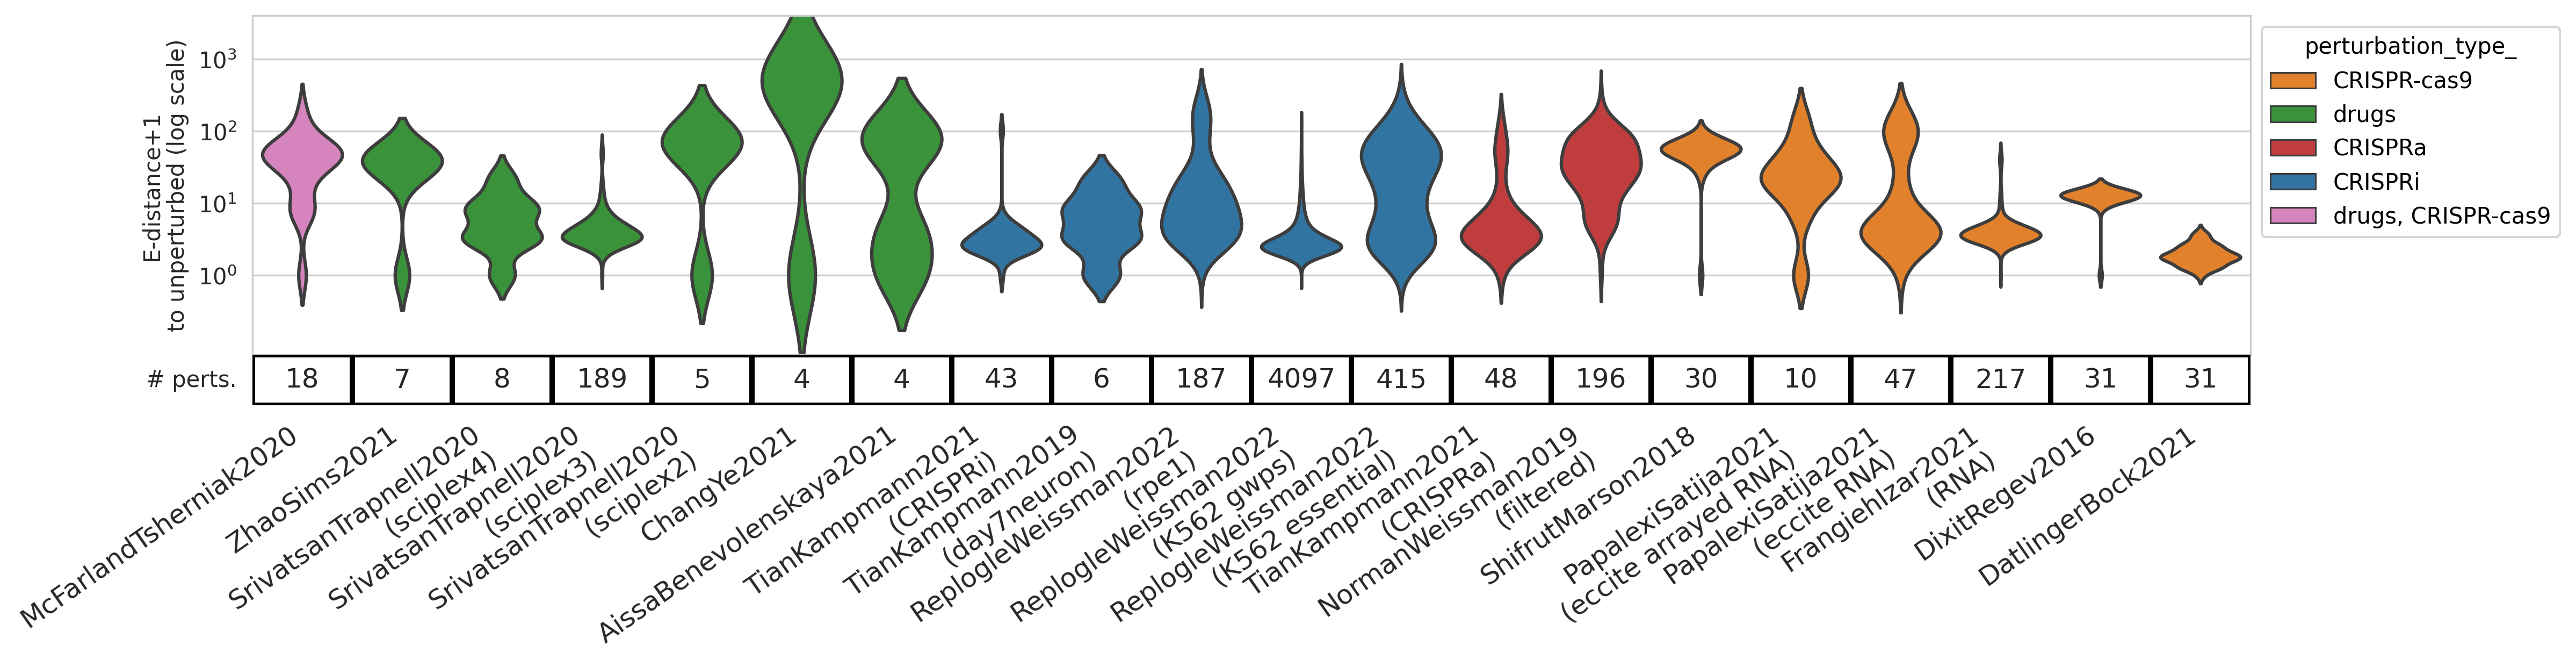

In [71]:
# setup figure
scale = 0.8  # control text to plot size
with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(2,1, figsize=[20 * scale, 4 * scale], dpi=300, 
                           gridspec_kw={'height_ratios': [10,1.5], 'hspace': 0})

# plot edistance violins
ax=axs[0]
# set negative E-dists to zero, add 1 and then take log10
df['tmp'] = np.log10(np.clip(df['distance'], 0, np.infty)+1)  # avoids long lower tail
vp = sns.violinplot(data=df, x='dataset_pretty', y='tmp', inner=None, dodge=False, hue='perturbation_type_', order=order, bw=.4,
                    palette=colors_perturbation_types, ax=ax)
ax.set_ylabel('E-distance+1\nto unperturbed (log scale)')
ax.set_xlabel('')
ax.set_xticklabels('')
# log scale y ticks
from matplotlib import ticker as mticker
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
ymin, ymax = ax.get_ylim()
tick_range = np.arange(0, 4)
ax.yaxis.set_ticks(tick_range)
ax.yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
ax.set_ylim([-1.1, 3.6])
sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1,1))

# little boxed with # of perts after filtering
ax = axs[1]
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('bla', ['white', 'white'], N=2)
sns.heatmap(np.zeros_like(Ns.T), ax=ax, cbar=False, cmap=cmap, annot=Ns.T, fmt='', linewidths=2, linecolor='k',
            annot_kws={'fontsize': 12})
ax.set_xticklabels(order, rotation=35, ha='right', fontsize=12)
ax.set_yticklabels(['# perts.'], rotation=0)
# save and plot
#pl.savefig(f'{figure_path}/Fig4B.pdf', bbox_inches='tight')
pl.show()

# Fig4C

In [123]:
df = pd.read_csv('../snakemake/tables/edist_to_control_NormanWeissman2019_filtered_tables.csv', index_col=0)
df.index.name='perturbation'
tab = pd.read_csv('../snakemake/tables/etest_NormanWeissman2019_filtered_tables.csv', index_col=0)
tab.index.name='perturbation'
tab.drop(['edist', 'log10_edist'], inplace=True, axis=1)  # redundant
df = pd.concat([df, tab], axis=1)

In [124]:
df.head()

,distance,pvalue,significant,pvalue_adj,significant_adj
perturbation,,,,,
control,0.000000,0.0001,True,0.019410,True
KLF1,29.208530,0.0001,True,0.019410,True
BAK1,2.494714,0.0096,True,0.032567,True
CEBPE,86.755892,0.0001,True,0.019410,True
CEBPE_RUNX1T1,32.097706,0.0001,True,0.019410,True


In [135]:
df['significant_'] = df['pvalue'] < 0.001

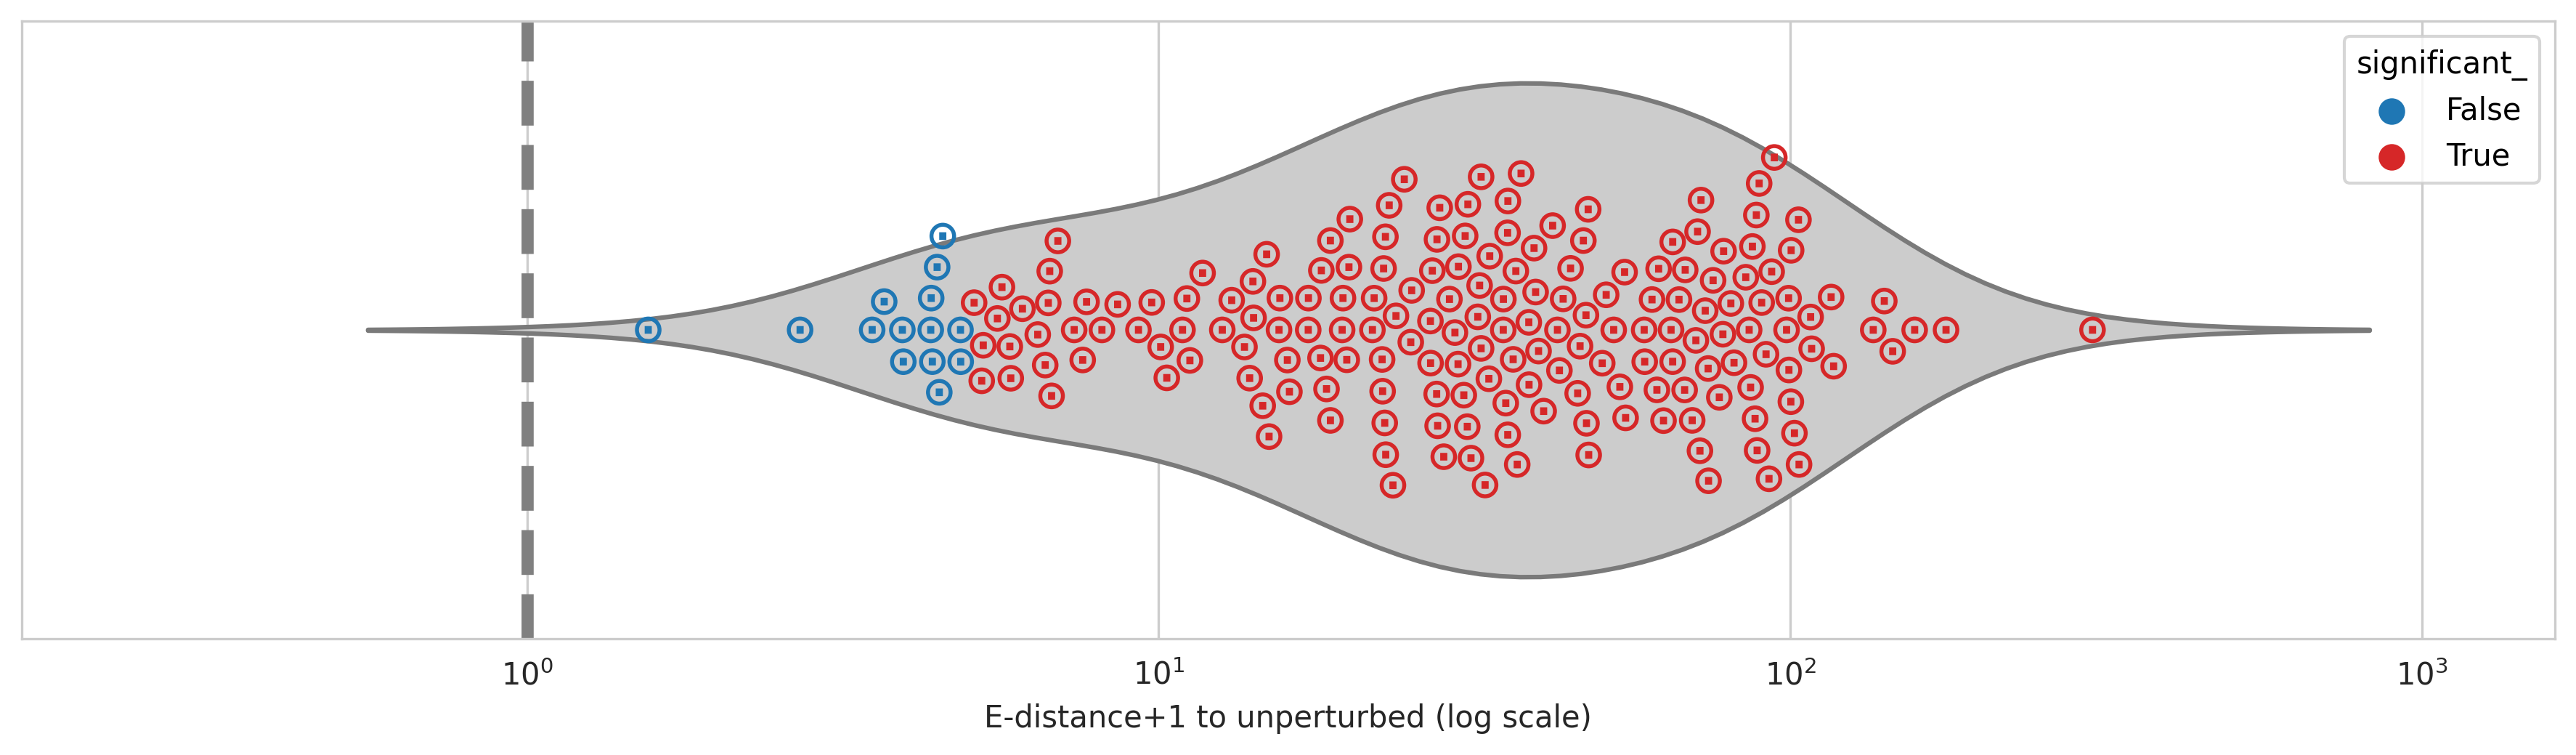

In [136]:
scale=0.75
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=[20*scale, 5*scale], dpi=300)
df['tmp'] = np.log10(np.clip(df['distance'], 0, np.infty)+1)
# np.log10(estats_control['E-statistic']+1)
sns.violinplot(data=df.drop('control'), x='tmp', inner=None, color=".8", width=0.8, bw=0.5)
ax = sns.swarmplot(data=df.drop('control'), x=df.drop('control')['tmp'], y=['']*len(df.drop('control')), size=10, marker='$\mathbf{\odot}$',
                   edgecolors='white', linewidth=0, hue='significant_', palette=['tab:blue', 'tab:red'])
pl.xlabel('E-distance+1 to unperturbed (log scale)')
ax.axvline(0, c='grey', linestyle='--', linewidth=4)

# log scale x ticks
from matplotlib import ticker as mticker
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
xmin, xmax = ax.get_xlim()
tick_range = np.arange(0, xmax)
ax.xaxis.set_ticks(tick_range)
ax.xaxis.set_ticks([np.log10(x+1) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
ax.set_xlim([-0.8, 3.21])
# pl.savefig(f'{figure_path}/Fig4C.pdf', bbox_inches='tight')
pl.show()

# Fig4D

In [110]:
indices = list(df['distance'].sort_values().index.drop('control'))
N = 3
top=indices[-N:]
bot=indices[:N]

In [111]:
ed = pd.read_csv('../snakemake/tables/pairwise_edist_NormanWeissman2019_filtered_tables.csv', index_col=0)

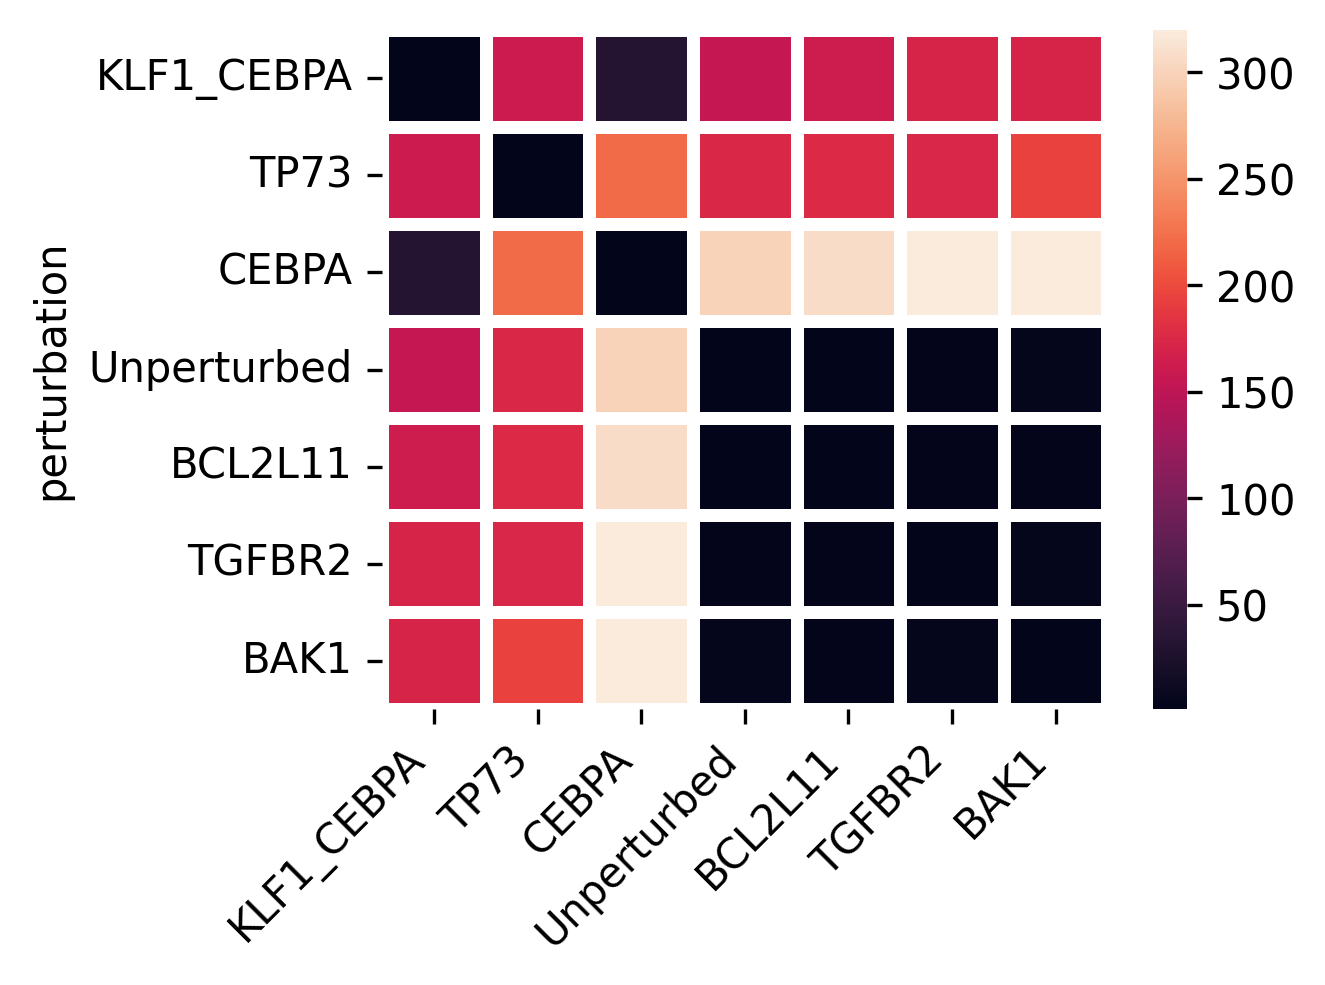

In [112]:
scale=0.3
pl.subplots(figsize=[13*scale,10*scale], dpi=300)
conds = top + ['control'] + bot
sub = ed.loc[conds, conds] + 1
sub = sub.rename({'control': 'Unperturbed'}, axis=1).rename({'control': 'Unperturbed'}, axis=0)
sns.heatmap(sub, robust=False, linewidth=3)
pl.xticks(rotation=45, ha='right')
# pl.savefig(f'{figure_path}/Fig4D.pdf', bbox_inches='tight')
pl.show()

# Fig4E

In [113]:
TEMPDIR = Path("/fast/scratch/users/peidlis_c/perturbation_resource_paper/")
adata = sc.read(TEMPDIR / 'tmp_data_NormanWeissman2019_filtered.h5')

In [119]:
sdata = adata[np.isin(adata.obs.perturbation, top+['control'])].copy()  # bot
sc.pp.pca(sdata, use_highly_variable=False)
sc.pp.neighbors(sdata)
sc.tl.umap(sdata)

# ['bot', 'control', 'top']
sdata.uns['group_colors'] = ['tab:grey', 'tab:red']  # ['tab:blue', 'tab:grey', 'tab:red']
from matplotlib.cm import get_cmap
colors_top = {g: get_cmap('Reds')((i+1)/N) for i, g in enumerate(top)}
colors_bot = {g: get_cmap('Blues')((i+1)/N) for i, g in enumerate(bot)}
colors_control = {'control': 'tab:grey'}
colors = {**colors_top, **colors_bot, **colors_control}
sdata.uns['perturbation_colors'] = [colors[g] for g in np.sort(pd.unique(sdata.obs.perturbation))]

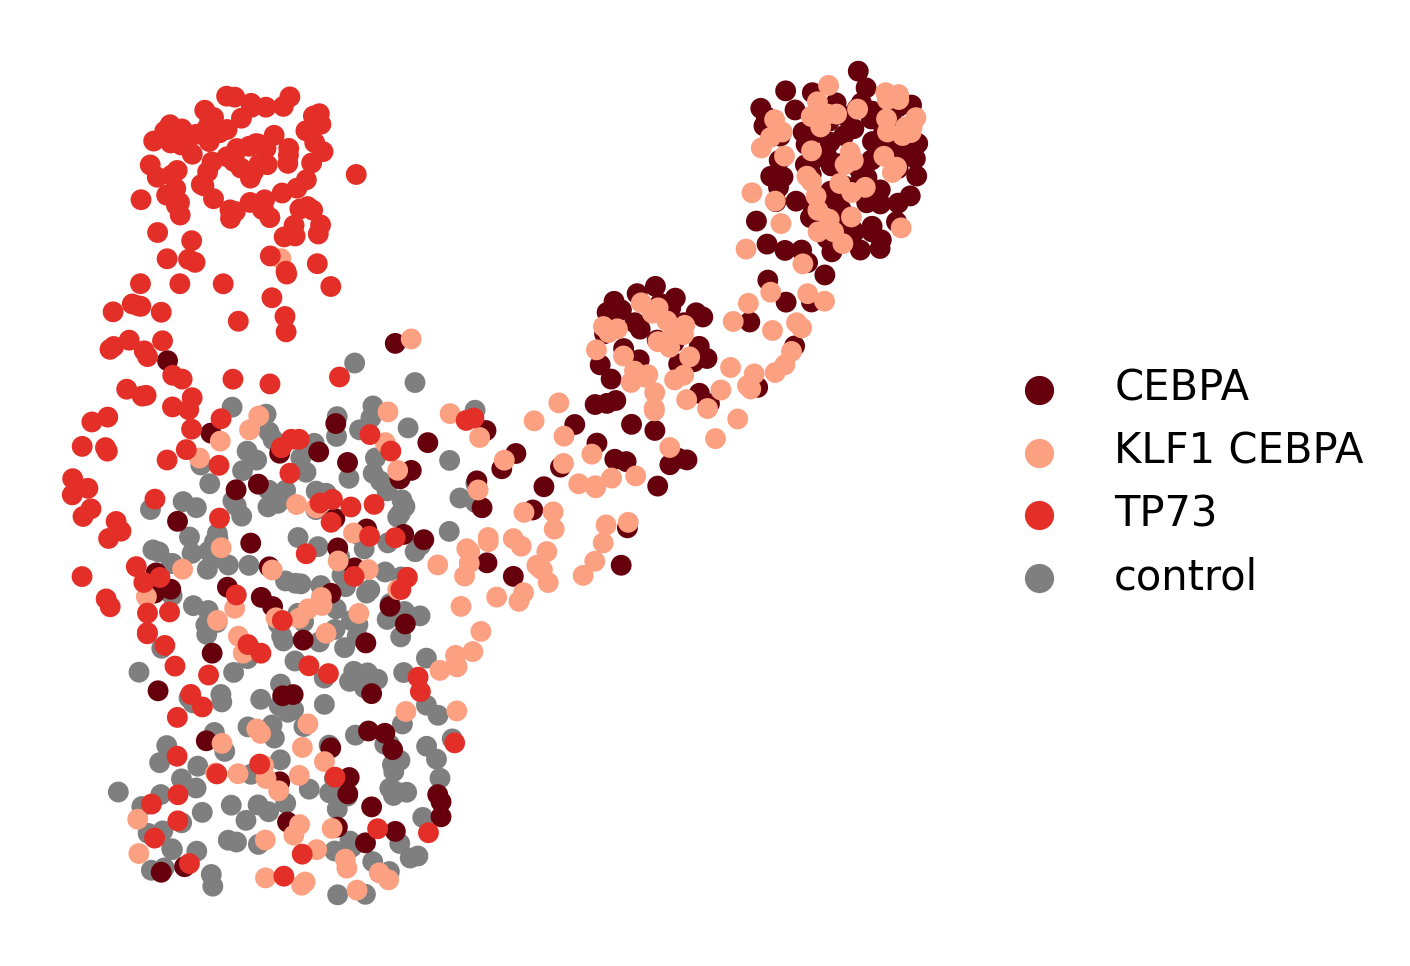

In [120]:
scv.pl.scatter(sdata, color='perturbation', legend_loc='right margin', figsize=[4,4], show=False, dpi=300, title='', s=100)
# pl.savefig(f'{figure_path}/Fig4E_top.pdf', bbox_inches='tight')
pl.show()

In [116]:
sdata = adata[np.isin(adata.obs.perturbation, bot+['control'])].copy()  # bot
sc.pp.pca(sdata, use_highly_variable=False)
sc.pp.neighbors(sdata)
sc.tl.umap(sdata)

# ['bot', 'control', 'top']
sdata.uns['group_colors'] = ['tab:blue', 'tab:grey']  # ['tab:blue', 'tab:grey', 'tab:red']
from matplotlib.cm import get_cmap
colors_top = {g: get_cmap('Reds')((i+1)/N) for i, g in enumerate(top)}
colors_bot = {g: get_cmap('Blues')((i+1)/N) for i, g in enumerate(bot)}
colors_control = {'control': 'tab:grey'}
colors = {**colors_top, **colors_bot, **colors_control}
sdata.uns['perturbation_colors'] = [colors[g] for g in np.sort(pd.unique(sdata.obs.perturbation))]

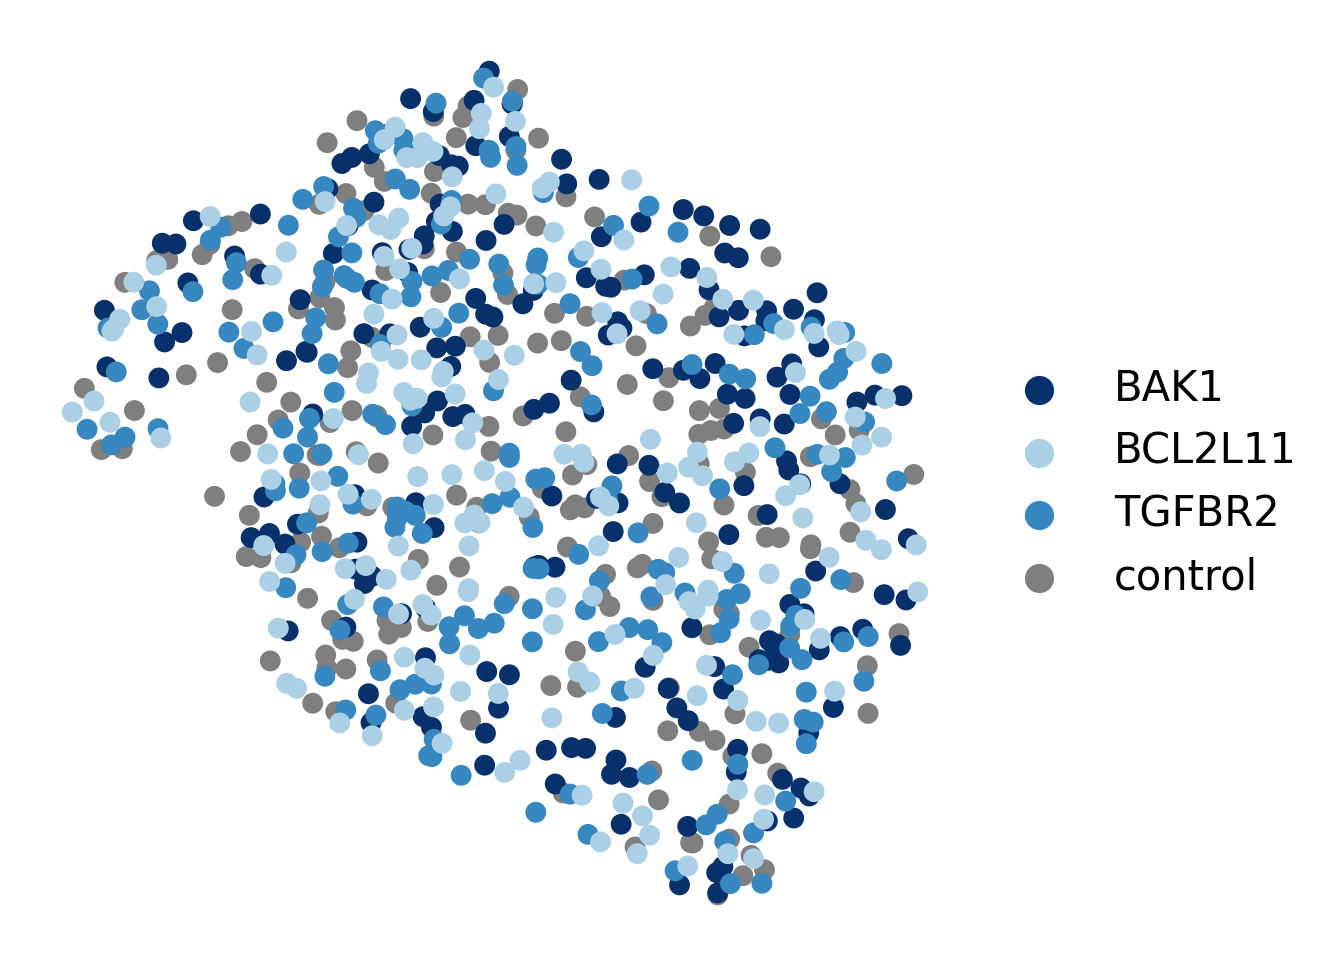

In [118]:
scv.pl.scatter(sdata, color='perturbation', legend_loc='right margin', figsize=[4,4], show=False, dpi=300, title='', s=100)
#pl.savefig(f'{figure_path}/Fig4E_bottom.pdf', bbox_inches='tight')
pl.show()

# SuppTab4

In [153]:
# get etest results and aggregate
tabs=[]
files = [x for x in Path('../snakemake/tables/').glob('etest_*.csv')]
for file in files:
    tab = pd.read_csv(file, index_col=0)
    tab.index.name='perturbation'
    tab = tab.reset_index()
    tab['dataset'] = file.name.replace('etest_','').replace('_tables.csv', '')
    tabs.append(tab)

df = pd.concat(tabs, axis=0)
df = df.drop('log10_edist', axis=1)
df.columns=['perturbation', 'uncorrected_edist_to_unperturbed', 'pvalue', 'significant', 'pvalue_adj', 'significant_adj', 'dataset']
# df.to_csv(f'{supp_path}/SuppTab4.csv')

# SuppFig4C (TODO)

In [157]:
df = pd.read_csv('../snakemake/tables/edist_to_control_NormanWeissman2019_filtered_tables.csv', index_col=0)
df.index.name='perturbation'
tab = pd.read_csv('../snakemake/tables/etest_NormanWeissman2019_filtered_tables.csv', index_col=0)
tab.index.name='perturbation'
tab.drop(['edist', 'log10_edist'], inplace=True, axis=1)  # redundant
df = pd.concat([df, tab], axis=1).drop('control')

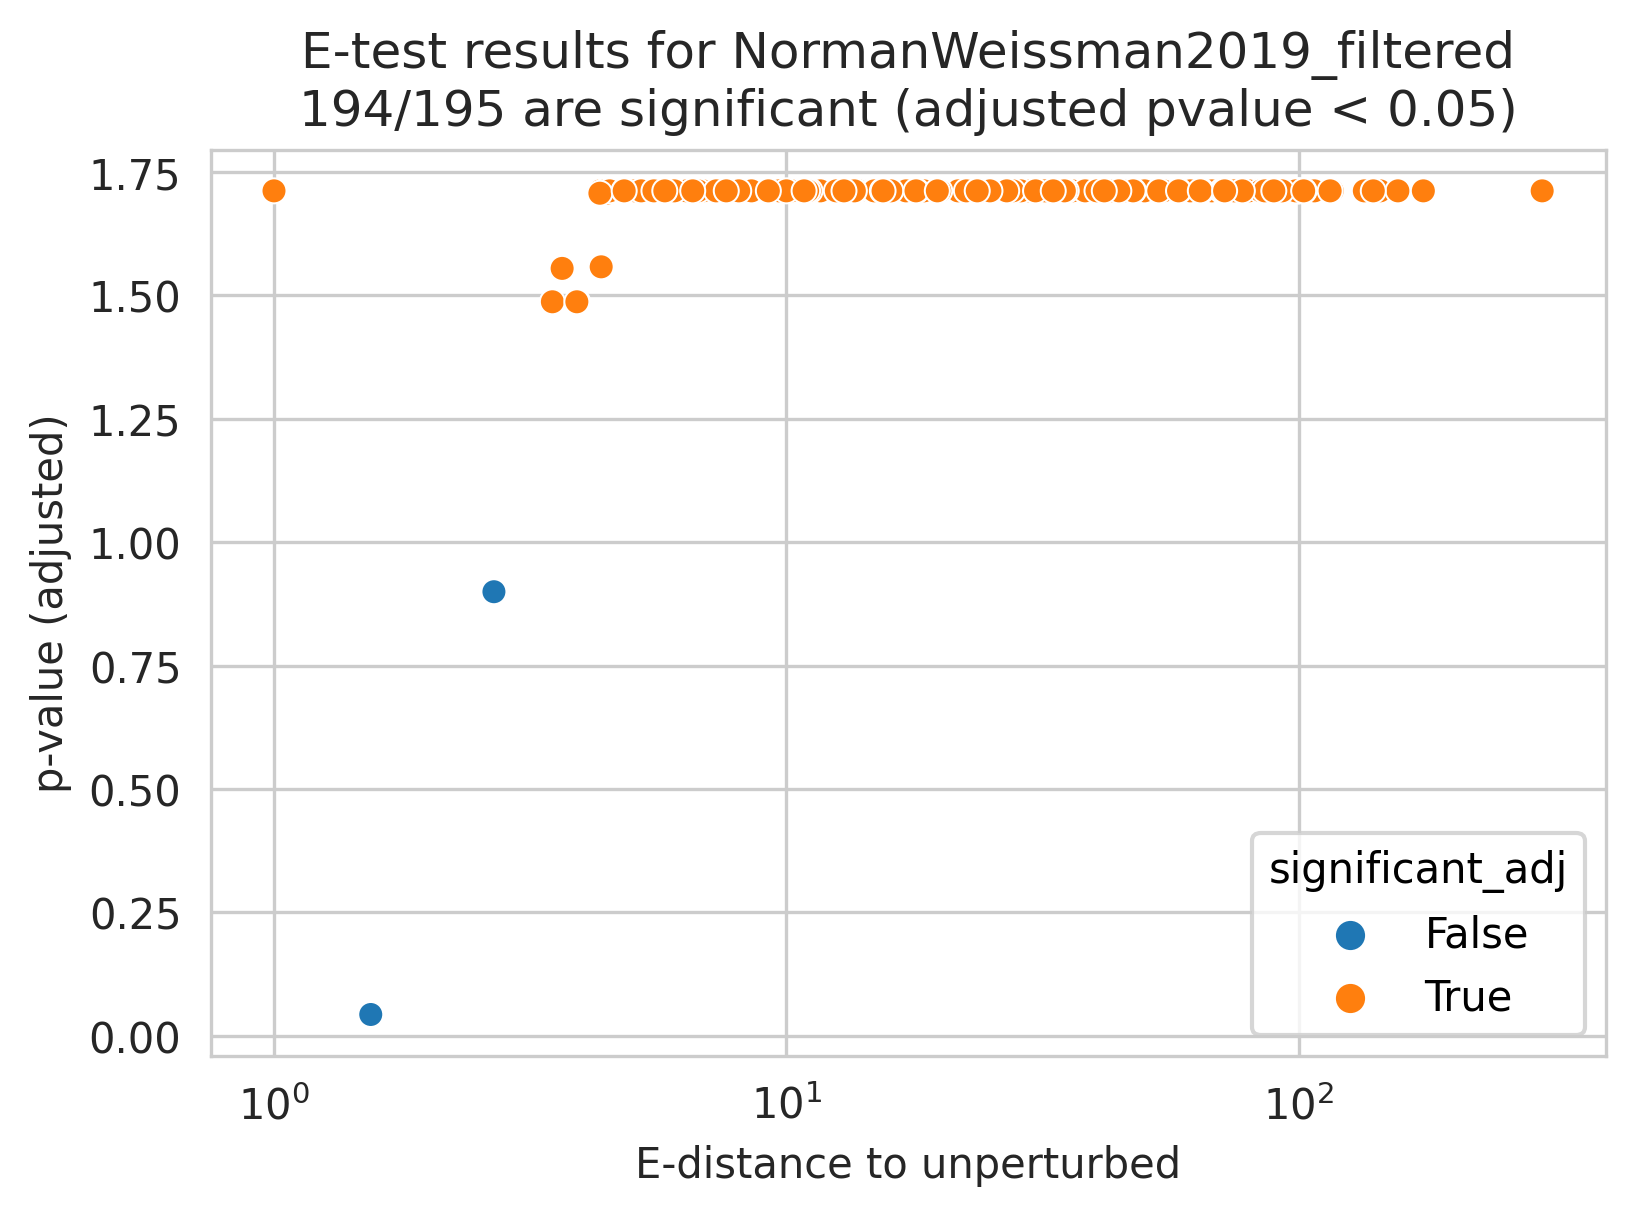

In [163]:
pseudocount = 1
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(dpi=300)
sns.scatterplot(data=df, x=df.distance+pseudocount, y=-np.log10(tab.pvalue_adj), hue='significant_adj')
pl.xlabel(f'E-distance to unperturbed')
sig = np.sum(df['significant'])
total = len(df) - 1
pl.title(f'E-test results for NormanWeissman2019_filtered\n{sig}/{total} are significant (adjusted pvalue < 0.05)')
pl.xscale('log')
pl.ylabel('p-value (adjusted)')
# pl.savefig(f'{supp_path}/SuppFig4B.pdf', bbox_inches='tight')
pl.show()

# SuppFig4D

In [165]:
ed = pd.read_csv('../snakemake/tables/pairwise_edist_NormanWeissman2019_filtered_tables.csv', index_col=0)

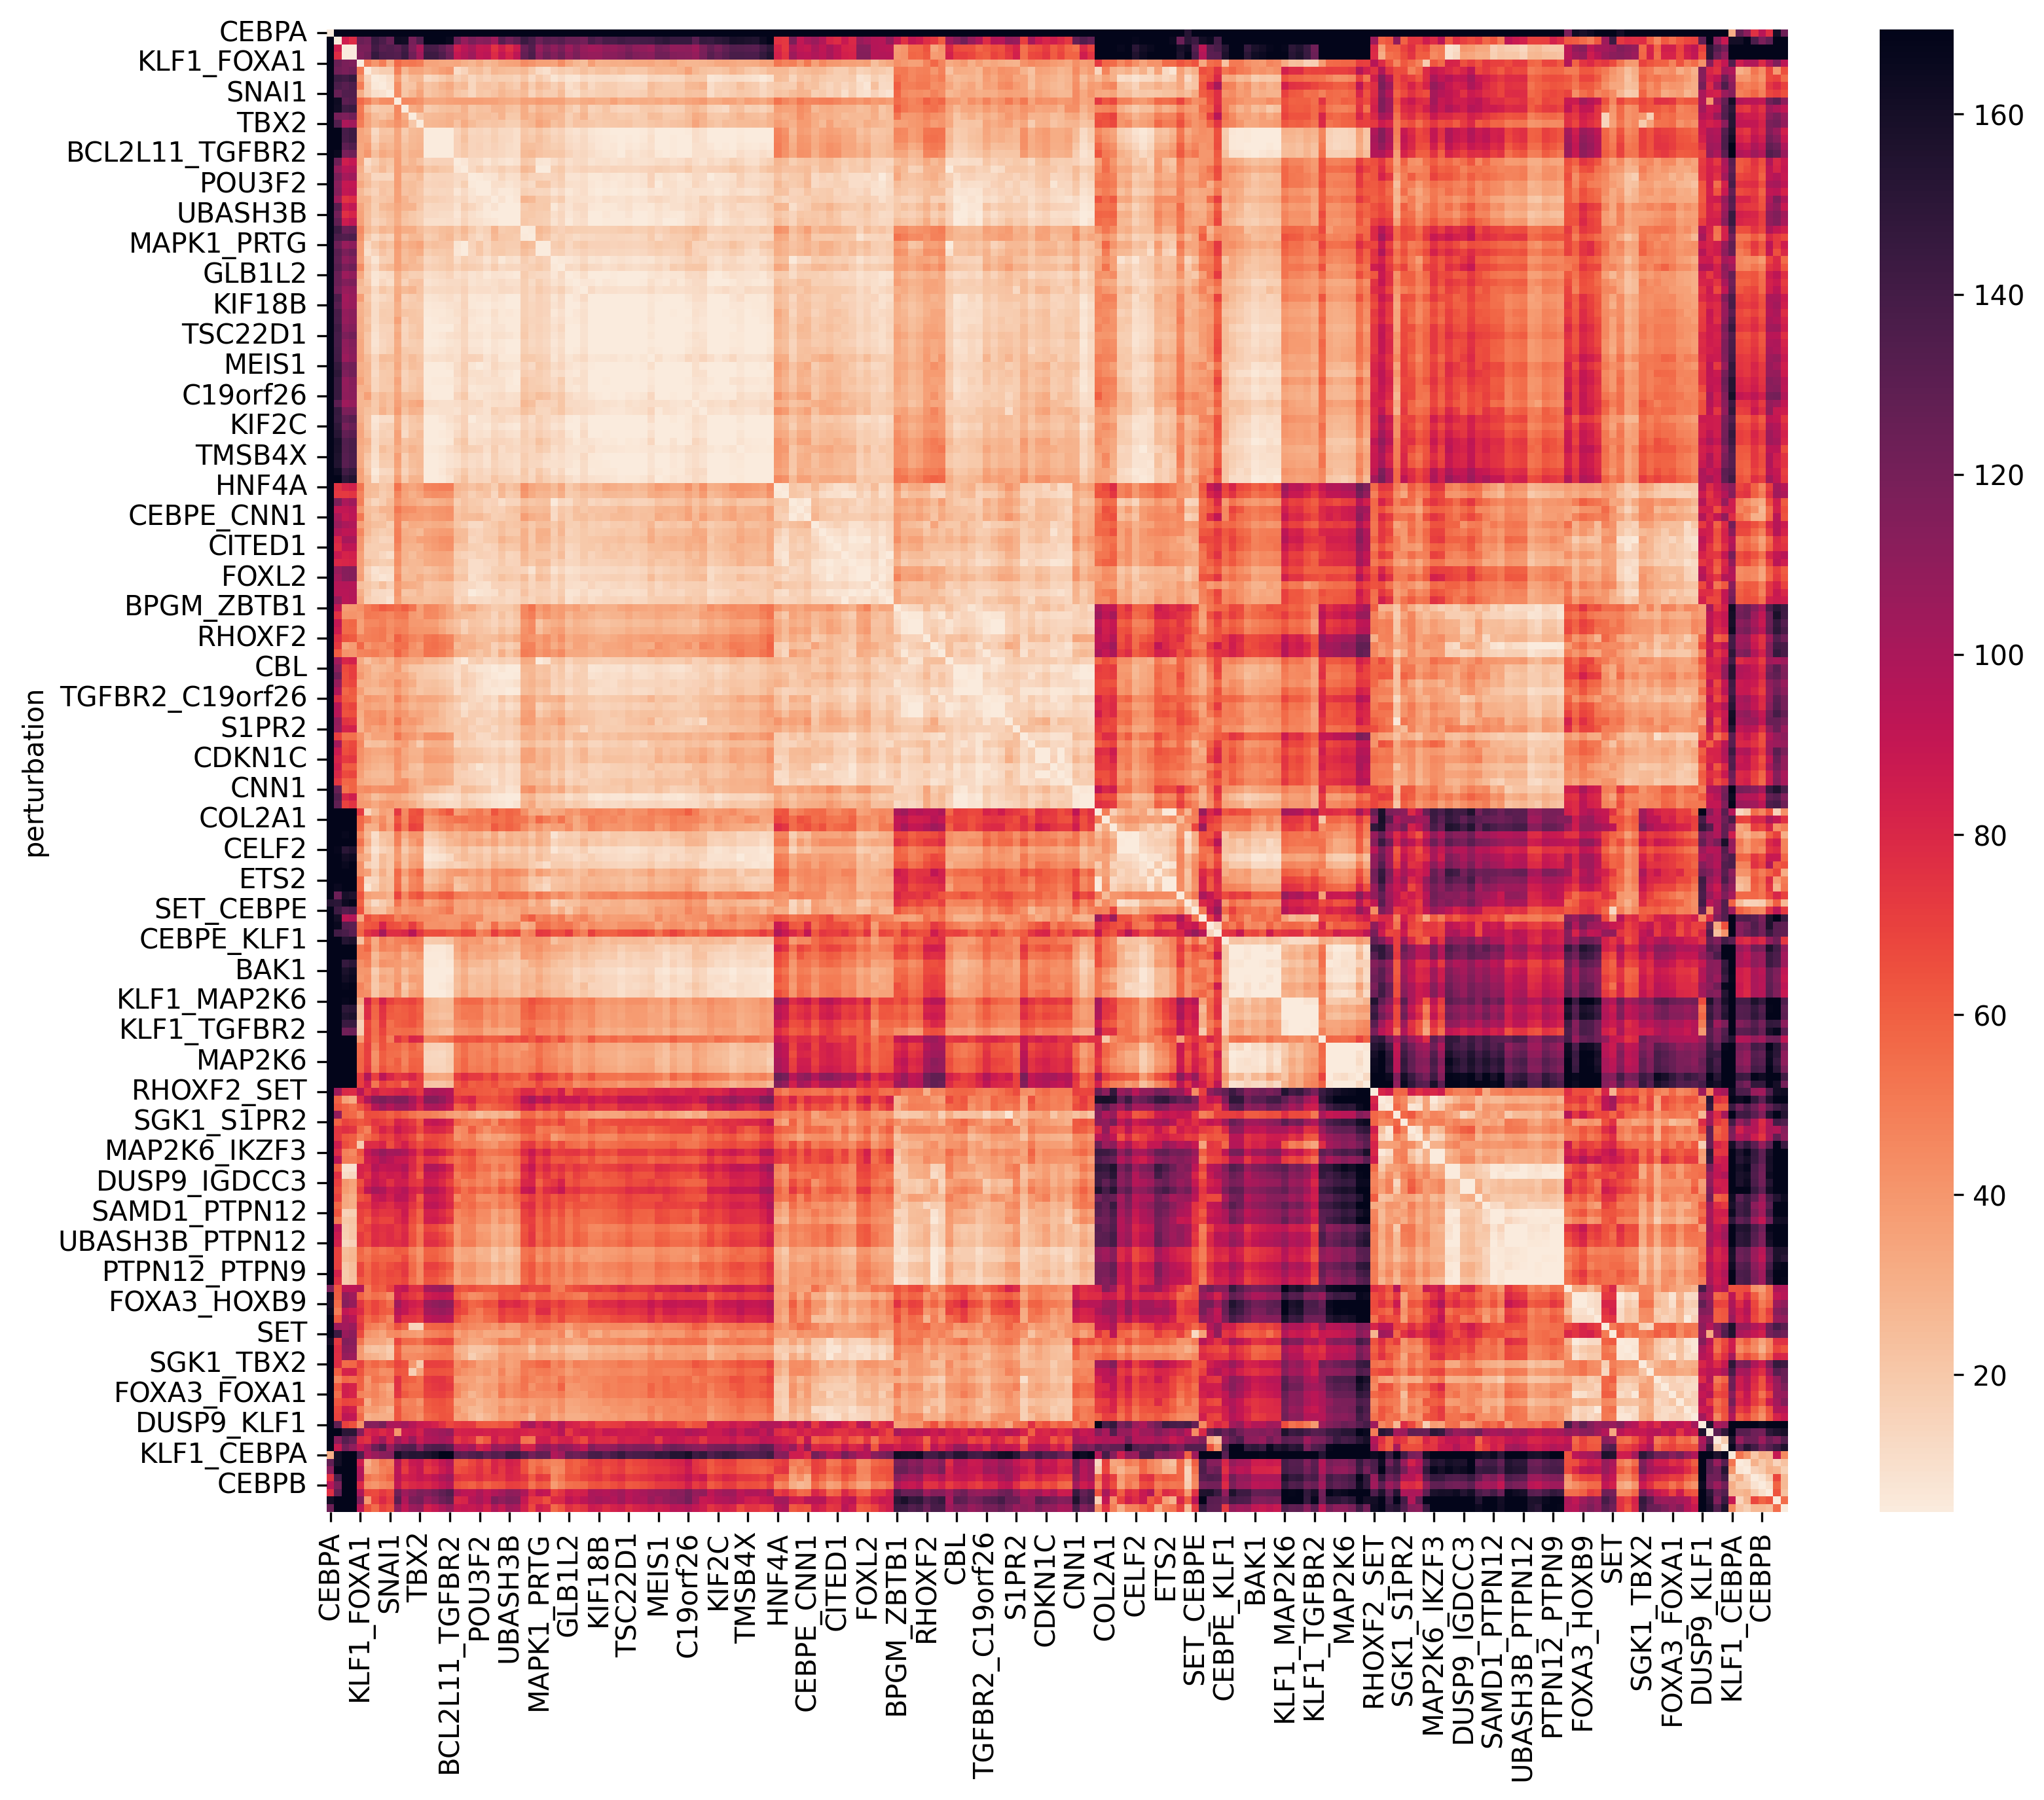

In [168]:
ed = cluster_matrix(ed, 'both')
pl.figure(figsize=[12,10], dpi=300)
sns.heatmap(ed, robust=True, cmap='rocket_r')
# pl.savefig(f'{supp_path}/SuppFig4D.pdf', bbox_inches='tight')
pl.show()

# SuppFig4X (TODO)

In [185]:
# get etest results and aggregate
tabs=[]
files = [x for x in Path('../snakemake/tables/').glob('etest_*.csv')]
for file in files:
    tab = pd.read_csv(file, index_col=0)
    tab.index.name='perturbation'
    tab = tab.reset_index()
    tab['dataset'] = file.name.replace('etest_','').replace('_tables.csv', '')
    tabs.append(tab)

df = pd.concat(tabs, axis=0)
df = df.drop('log10_edist', axis=1)
df.columns=['perturbation', 'uncorrected_edist_to_unperturbed', 'pvalue', 'significant', 'pvalue_adj', 'significant_adj', 'dataset']

In [217]:
# annotate
nperts = pd.DataFrame(df.value_counts('dataset'), columns=['nperts'])
significant_adj = pd.DataFrame(df.groupby('dataset').sum()['significant_adj'], columns=['significant_adj'])
df['significant_'] = df.pvalue<0.001
significant_ = pd.DataFrame(df.groupby('dataset').sum()['significant_'], columns=['significant_'])
mean_edist = pd.DataFrame(df.groupby('dataset').mean()['uncorrected_edist_to_unperturbed']+1)

In [218]:
# extract
dfx = pd.concat([nperts, mean_edist, significant_adj, significant_], axis=1)

# calx % sig
dfx['perc_sig'] = np.round(100* dfx['significant_'] / dfx['nperts'], 2)

# fix typo
dfx = dfx.rename({'McFarlandTshemiak2020_all_expts_combined': 'McFarlandTsherniak2020'})

# make labels pretty and more compact
dfx['dataset_pretty'] = [x.replace('TAP_SCREEN__', '') for x in dfx.index]
dfx['dataset_pretty'] = [x.replace('_', '\n(', 1)+')' if '_' in x else x for x in dfx.dataset_pretty]
dfx['dataset_pretty'] = [x.replace('_', ' ') for x in dfx.dataset_pretty]

# add metadata
metadata = pd.read_csv('../../metadata/scperturb_dataset_info_140922.csv', index_col=0)
metadata['dataset_id'] = [i if pd.isna(x) else f'{i}_{x}' for i, x in zip(metadata.index, metadata.dataset_index)]
metadata = metadata.set_index('dataset_id')
dfx['perturbation_type'] = None
for index in dfx.index:
    dfx.loc[index, 'perturbation_type'] = pd.unique(metadata.loc[index, 'Perturbation'])[0]
dfx.perturbation_type[dfx.perturbation_type=='CRISPR-cas9, TCR stim'] = 'CRISPR-cas9'

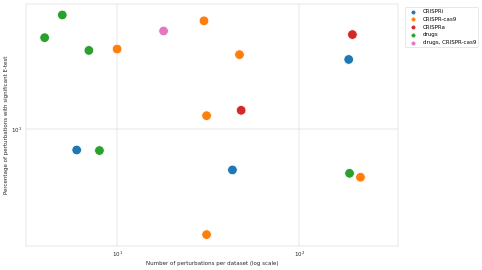

In [224]:
from adjustText import adjust_text

x = 'nperts'
y = 'uncorrected_edist_to_unperturbed'

scale = 2
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(dpi=40, figsize=[6*scale,4*scale])
scat=sns.scatterplot(data=dfx, x=x, y=y, ax=ax, hue='perturbation_type', palette=colors_perturbation_types, zorder=100, s=300)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Number of perturbations per dataset (log scale)')
ax.set_ylabel('Percentage of perturbations with significant E-test')

ax.set_xlim([-45, 350])  # make more space for annotations

# annotate
if False:
    texts = []
    for xx, yy, s in zip(dfx[x], dfx[y], dfx.dataset_pretty):
        texts.append(pl.text(xx, yy, s))
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=2.5),
                expand_text=(1.15, 1.5),
                expand_points=(1.15, 1.5),
                expand_objects=(1.15, 1.5)
               )
scat.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
# pl.savefig(f'{supp_path}/SuppFig4B.pdf', bbox_inches='tight')
pl.show()